[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/qubvel/segmentation_models.pytorch/blob/main/examples/binary_segmentation_intro.ipynb)

🇭 🇪 🇱 🇱 🇴 👋

This example shows how to use `segmentation-models-pytorch` for **binary** semantic segmentation. We will use the [The Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) (this is an adopted example from Albumentations package [docs](https://albumentations.ai/docs/examples/pytorch_semantic_segmentation/), which is strongly recommended to read, especially if you never used this package for augmentations before).

The task will be to classify each pixel of an input image either as pet 🐶🐱 or as a background.


What we are going to overview in this example:  

 - 📜 `Datasets` and `DataLoaders` preparation (with predefined dataset class).  
 - 📦 `LightningModule` preparation: defining training, validation and test routines.  
 - 📈 Writing `IoU` metric inside the `LightningModule` for measuring quality of segmentation.  
 - 🐶 Results visualization.


> It is expected you are familiar with Python, PyTorch and have some experience with training neural networks before!

In [1]:
%%capture
!pip install -U git+https://github.com/qubvel-org/segmentation_models.pytorch
!pip install lightning albumentations

In [16]:
import os

import torch
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from torch.optim import lr_scheduler
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
import wandb
from pytorch_lightning.loggers import WandbLogger

## Dataset

In this example we will use predefined `Dataset` class for simplicity. The dataset actually read pairs of images and masks from disk and return `sample` - dictionary with keys `image`, `mask` and others (not relevant for this example).

⚠️ **Dataset preparation checklist** ⚠️

In case you writing your own dataset, please, make sure that:

1.   **Images** 🖼  
    ✅   Images from dataset have **the same size**, required for packing images to a batch.  
    ✅   Images height and width are **divisible by 32**. This step is important for segmentation, because almost all models have skip-connections between encoder and decoder and all encoders have 5 downsampling stages (2 ^ 5 = 32). Very likely you will face with error when model will try to concatenate encoder and decoder features if height or width is not divisible by 32.  
    ✅   Images have **correct axes order**. PyTorch works with CHW order, we read images in HWC [height, width, channels], don`t forget to transpose image.
2.   **Masks** 🔳  
    ✅   Masks have **the same sizes** as images.   
    ✅   Masks have only `0` - background and `1` - target class values (for binary segmentation).  
    ✅   Even if mask don`t have channels, you need it. Convert each mask from **HW to 1HW** format for binary segmentation (expand the first dimension).

Some of these checks are included in LightningModule below during the training.

❗️ And the main rule: your train, validation and test sets are not intersects with each other!

In [17]:
from dataset import CustomImageMaskDataset

In [ ]:
# download data
root = "Dataset/"
#SimpleGrayDataset.download(root)

In [ ]:
from dataset import generate_dataset
from torch.utils.data import DataLoader
import os

# get dataset
train_dataset, valid_dataset, test_dataset = generate_dataset(root)

assert set(test_dataset.filenames).isdisjoint(set(train_dataset.filenames))
assert set(test_dataset.filenames).isdisjoint(set(valid_dataset.filenames))
assert set(train_dataset.filenames).isdisjoint(set(valid_dataset.filenames))

# create DataLoader
n_cpu = os.cpu_count()
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=n_cpu)
valid_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=n_cpu)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=n_cpu)


Train size: 391
Valid size: 84
Test size: 84


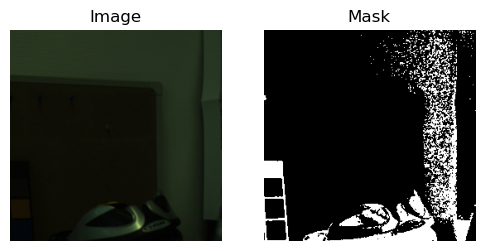

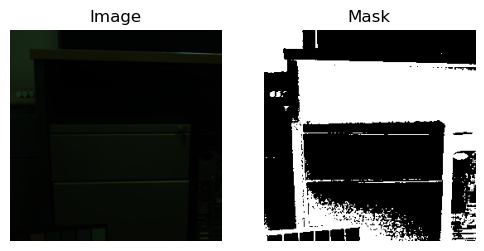

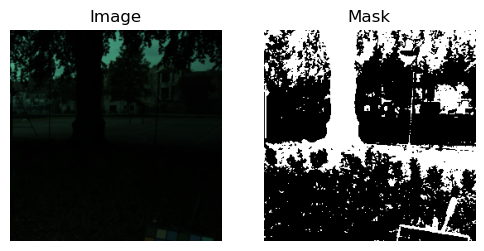

In [20]:
import matplotlib.pyplot as plt
import torch

def show_sample(dataset, index):
    sample = dataset[index]
    image = sample["image"]
    mask = sample["mask"]

    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0)
    if isinstance(mask, torch.Tensor):
        mask = mask.squeeze()

    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.title("Image")
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Mask")
    plt.imshow(mask, cmap="gray")
    plt.axis("off")

    plt.show()


show_sample(train_dataset, 0)
show_sample(valid_dataset, 0)
show_sample(test_dataset, 0)

## Model

In [21]:
# Some training hyperparameters
EPOCHS = 30
T_MAX = EPOCHS * len(train_dataloader)
OUT_CLASSES = 1

In [ ]:
class GrayModel(pl.LightningModule):
    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch,
            encoder_name=encoder_name,
            in_channels=in_channels,
            classes=out_classes,
            **kwargs,
        )
        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

        # initialize step metics
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std 
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        image = batch["image"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32,
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        if batch.get("trimap", None) != None:
            del batch["trimap"]
            #print("trimap deleted") 

        mask = batch["mask"]
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0


        logits_mask = self.forward(image)

        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(
            pred_mask.long(), mask.long(), mode="binary"
        )
        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(
            tp, fp, fn, tn, reduction="micro-imagewise"
        )
        

        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset
        # with "empty" images (images without target class) a large gap could be observed.
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        train_loss_info = self.shared_step(batch, "train")
        # append the metics of each step to the
        self.training_step_outputs.append(train_loss_info)
        # add the result of loss to wandb
        self.log("train_loss", train_loss_info["loss"], on_step=True, on_epoch=True, prog_bar=True)
        return train_loss_info

    def on_train_epoch_end(self):
        self.shared_epoch_end(self.training_step_outputs, "train")
        # empty set output list
        self.training_step_outputs.clear()
        return

    def validation_step(self, batch, batch_idx):
        valid_loss_info = self.shared_step(batch, "valid")
        self.validation_step_outputs.append(valid_loss_info)
        # add the result of loss to wandb
        self.log("val_loss", valid_loss_info["loss"], on_step=False, on_epoch=True, prog_bar=True)
        return valid_loss_info

    def on_validation_epoch_end(self):
        self.shared_epoch_end(self.validation_step_outputs, "valid")
        self.validation_step_outputs.clear()
        return

    def test_step(self, batch, batch_idx):
        test_loss_info = self.shared_step(batch, "test")
        self.test_step_outputs.append(test_loss_info)
        # add the result of loss to wandb
        self.log("test_loss", test_loss_info["loss"], on_step=False, on_epoch=True, prog_bar=True)
        return test_loss_info

    def on_test_epoch_end(self):
        self.shared_epoch_end(self.test_step_outputs, "test")
        # empty set output list
        self.test_step_outputs.clear()
        return

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_MAX, eta_min=1e-5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1,
            },
        }
        return

In [ ]:
model = GrayModel("Unet", "resnet50", in_channels=3, out_classes=1)

In [11]:
import segmentation_models_pytorch as smp
# how many models can we use? 76
print(smp.encoders.get_encoder_names())

['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'resnext50_32x4d', 'resnext101_32x4d', 'resnext101_32x8d', 'resnext101_32x16d', 'resnext101_32x32d', 'resnext101_32x48d', 'dpn68', 'dpn68b', 'dpn92', 'dpn98', 'dpn107', 'dpn131', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152', 'se_resnext50_32x4d', 'se_resnext101_32x4d', 'densenet121', 'densenet169', 'densenet201', 'densenet161', 'inceptionresnetv2', 'inceptionv4', 'efficientnet-b0', 'efficientnet-b1', 'efficientnet-b2', 'efficientnet-b3', 'efficientnet-b4', 'efficientnet-b5', 'efficientnet-b6', 'efficientnet-b7', 'mobilenet_v2', 'xception', 'timm-efficientnet-b0', 'timm-efficientnet-b1', 'timm-efficientnet-b2', 'timm-efficientnet-b3', 'timm-efficientnet-b4', 'timm-efficientnet-b5', 'timm-efficientnet-b6', 'timm-efficientnet-b7', 'timm-efficientnet-b8', 'timm-efficientnet-l2', 'timm-tf_efficientnet_lite0', 'timm-tf_efficientnet_li

In [ ]:
import segmentation_models_pytorch as smp

print(smp.__all__)  # list of modules


['datasets', 'encoders', 'decoders', 'losses', 'metrics', 'Unet', 'UnetPlusPlus', 'MAnet', 'Linknet', 'FPN', 'PSPNet', 'DeepLabV3', 'DeepLabV3Plus', 'PAN', 'UPerNet', 'Segformer', 'from_pretrained', 'create_model', '__version__']


In [ ]:
#  'Unet', 'UnetPlusPlus', 'MAnet', 'Linknet', 'FPN', 'PSPNet', 'DeepLabV3', 'DeepLabV3Plus', 'PAN', 'UPerNet', 'Segformer',

## Training

In [ ]:
# wandb
wandb_logger = WandbLogger(project="Gray-segmentation", name="unet-resnet50-run")

trainer = pl.Trainer(
    max_epochs=EPOCHS,
    log_every_n_steps=1,
    logger=wandb_logger  # add wandb for loss
    #precision=16
)


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [26]:
wandb.init(project="Gray-segmentation", config={
    "epochs": EPOCHS,
    "arch": "UNet",
    "encoder": "resnet50",
    "lr": 2e-4,
    "batch_size": 64
})


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


In [27]:
# trainer = pl.Trainer(max_epochs=EPOCHS, log_every_n_steps=1)

trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=valid_dataloader,
)

/home/nh11256z/conda/envs/Oxbiseg/lib/python3.9/site-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params | Mode 
---------------------------------------------
0 | model   | Unet     | 32.5 M | train
1 | loss_fn | DiceLoss | 0      | train
---------------------------------------------
32.5 M    Trainable params
0         Non-trainable params
32.5 M    Total params
130.084   Total estimated model params size (MB)
224       Modules in train mode
0         Modules in eval mode


/home/nh11256z/conda/envs/Oxbiseg/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 64. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/home/nh11256z/conda/envs/Oxbiseg/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 20. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 0: 100%|██████████| 7/7 [00:09<00:00,  0.73it/s, v_num=w3p6, train_loss_step=0.486]

/home/nh11256z/conda/envs/Oxbiseg/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 7. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 29: 100%|██████████| 7/7 [00:20<00:00,  0.34it/s, v_num=w3p6, train_loss_step=0.209, val_loss=0.374, valid_per_image_iou=0.464, valid_dataset_iou=0.491, train_loss_epoch=0.259, train_per_image_iou=0.566, train_dataset_iou=0.645]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 7/7 [00:22<00:00,  0.31it/s, v_num=w3p6, train_loss_step=0.209, val_loss=0.374, valid_per_image_iou=0.464, valid_dataset_iou=0.491, train_loss_epoch=0.259, train_per_image_iou=0.566, train_dataset_iou=0.645]


## Validation and test metrics

In [40]:
# run validation dataset
valid_metrics = trainer.validate(model, dataloaders=valid_dataloader, verbose=False)
print(valid_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.57it/s]
[{'val_loss': 0.4602435231208801, 'valid_per_image_iou': 0.36962801218032837, 'valid_dataset_iou': 0.36962801218032837}]


In [28]:
# run test dataset
test_metrics = trainer.test(model, dataloaders=test_dataloader, verbose=False)
print(test_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 11.83it/s]
[{'test_loss': 0.3791549503803253, 'test_per_image_iou': 0.45008325576782227, 'test_dataset_iou': 0.4813605546951294}]


# Save model to HF Hub

Login to [HF hub](https://huggingface.co/) if you want to save your model to the hub. Then, you will be able to save and load model, save metrics, and dataset name!

In [ ]:
import torch
import matplotlib.pyplot as plt
import os


# Run validation dataset
valid_metrics = trainer.validate(model, dataloaders=valid_dataloader, verbose=False)
print("Validation Metrics:", valid_metrics)

# Run test dataset
test_metrics = trainer.test(model, dataloaders=test_dataloader, verbose=False)
print("Test Metrics:", test_metrics)

# Define path to save the model in Google Drive
save_path = "UnetRes50_ep30.pth"

# Save the model state dictionary
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

# Load the model from Google Drive
loaded_model = GrayModel("Unet", "resnet50", in_channels=3, out_classes=1)
loaded_model.load_state_dict(torch.load(save_path))
loaded_model.eval()  # Set to evaluation mode
print("Model loaded from Google Drive")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 12.31it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation Metrics: [{'val_loss': 0.3760088086128235, 'valid_per_image_iou': 0.45630547404289246, 'valid_dataset_iou': 0.4872657358646393}]
Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 12.56it/s]
Test Metrics: [{'test_loss': 0.35610902309417725, 'test_per_image_iou': 0.4709387719631195, 'test_dataset_iou': 0.5066944360733032}]
Model saved to UnetRes50_ep30.pth
Model loaded from Google Drive


# Result visualization

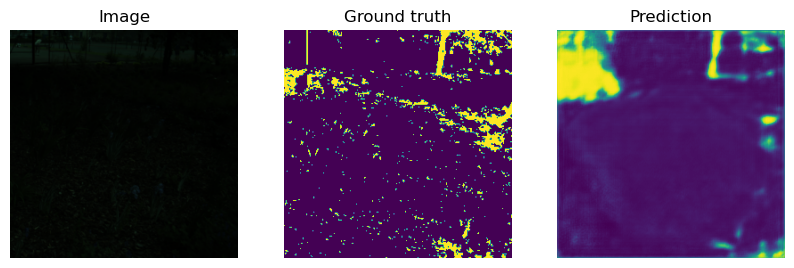

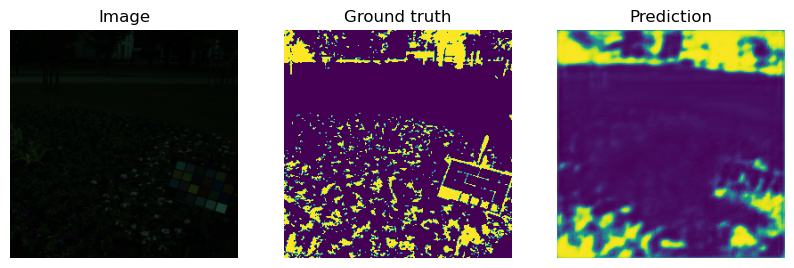

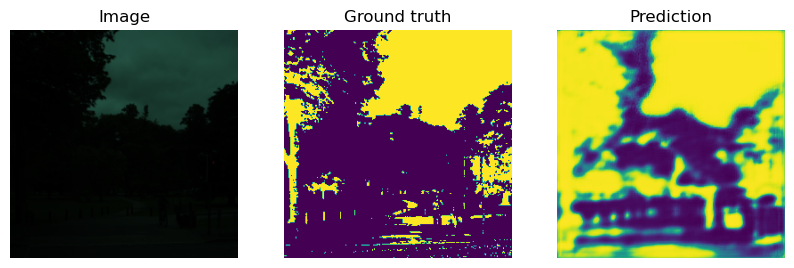

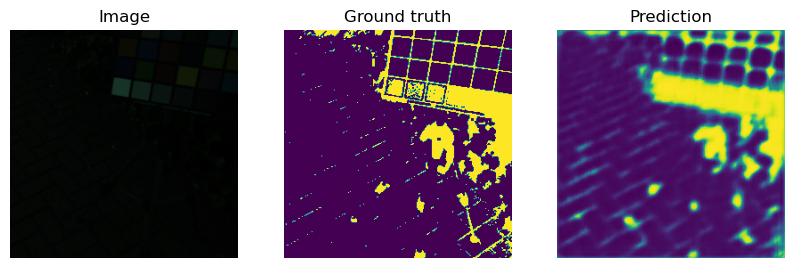

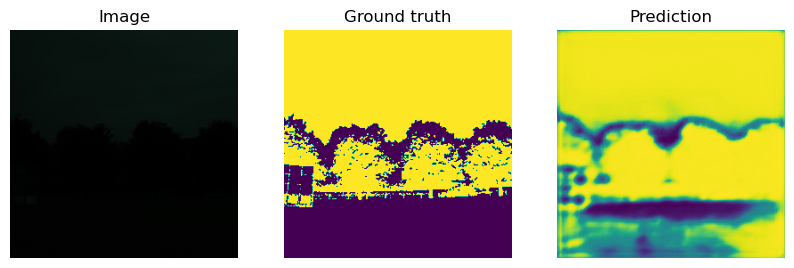

In [30]:
batch = next(iter(test_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch["image"])
pr_masks = logits.sigmoid()
for idx, (image, gt_mask, pr_mask) in enumerate(
    zip(batch["image"], batch["mask"], pr_masks)
):
    if idx <= 4:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image.numpy().transpose(1, 2, 0))
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.numpy().squeeze())
        plt.title("Ground truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask.numpy().squeeze())
        plt.title("Prediction")
        plt.axis("off")
        plt.show()
        
        wandb.log({
            f"example_{idx}": [
            wandb.Image(image.numpy().transpose(1, 2, 0), caption="Image"),
            wandb.Image(gt_mask.numpy().squeeze(), caption="GT"),
            wandb.Image(pr_mask.numpy().squeeze(), caption="Prediction"),
            ]
        })
        
    else:
        break

[0] Angular Error (degrees): 7.16


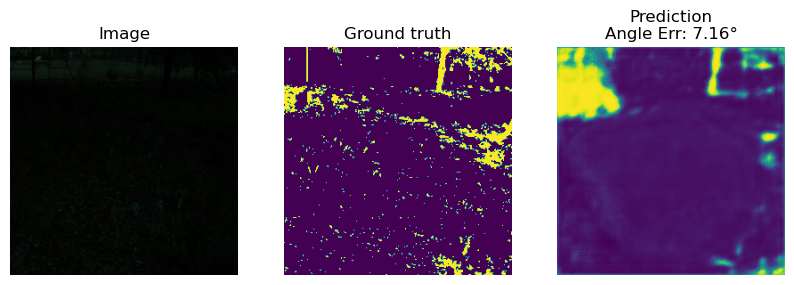

[1] Angular Error (degrees): 5.26


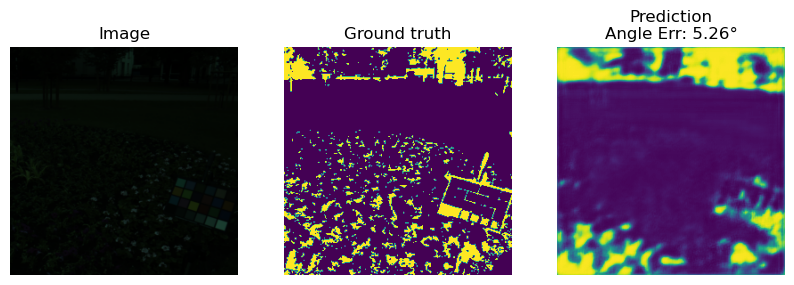

[2] Angular Error (degrees): 1.36


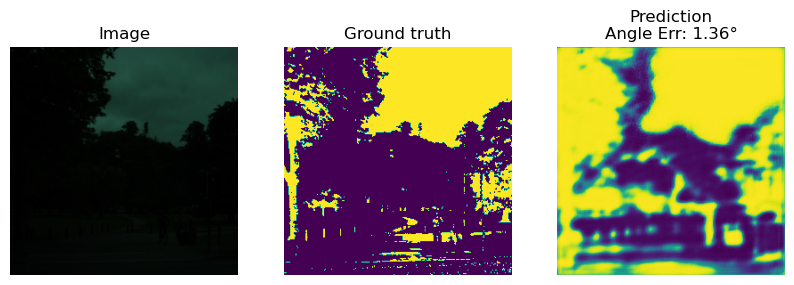

[3] Angular Error (degrees): 0.30


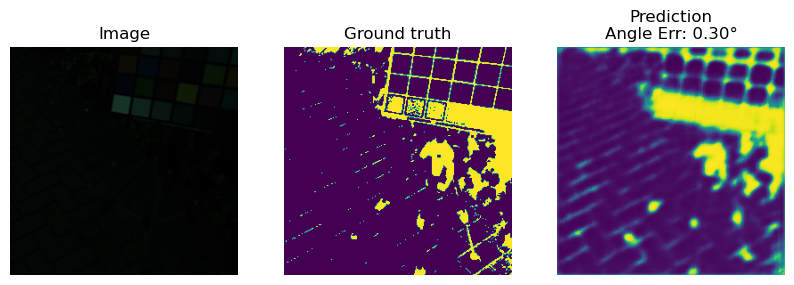

[4] Angular Error (degrees): 0.38


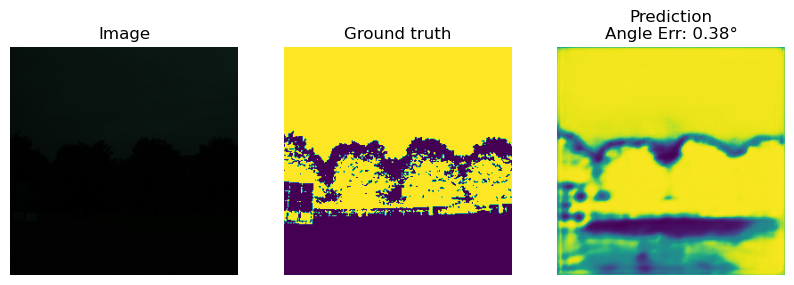

In [ ]:
import os
import pandas as pd
import numpy as np

illum_df = pd.read_csv("real_illum.csv")

# create the name of basefile except extension and path
illum_df["basename"] = illum_df["image"].apply(lambda x: os.path.splitext(os.path.basename(x))[0])

# make the dict
illum_dict = dict(zip(illum_df["basename"], illum_df[["r", "g", "b"]].values))


for idx in range(len(batch["image"])):
    if idx > 4:
        break

    image = batch["image"][idx]
    gt_mask = batch["mask"][idx]
    pr_mask = pr_masks[idx]

    # === get filenames ===
    filename = batch["filename"][idx]
    if isinstance(filename, bytes):
        filename = filename.decode()

    filename = os.path.splitext(os.path.basename(filename))[0]  # except extention and path

    if filename not in illum_dict:
        print(f"[{idx}] Filename '{filename}' not found in illum_dict")
        angular_error = None
    else:
        gt_illum = illum_dict[filename]
        gt_illum = gt_illum / np.linalg.norm(gt_illum)

        # === Angular Error  === 
        binary_mask = pr_mask.squeeze().numpy() > 0.5 # we can adjust the threshold, also improve the result
        img = image.permute(1, 2, 0).numpy()
        gray_pixels = img[binary_mask]

        if gray_pixels.shape[0] == 0:
            print(f"[{idx}] No gray pixels found.")
            angular_error = None
        else:
            est_illum = gray_pixels.mean(axis=0)
            est_illum /= np.linalg.norm(est_illum)

            dot = np.clip(np.dot(est_illum, gt_illum), -1.0, 1.0)
            angular_error = np.arccos(dot) * (180 / np.pi)
            print(f"[{idx}] Angular Error (degrees): {angular_error:.2f}")

    # === images ===
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze())
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.numpy().squeeze())
    title = f"Prediction\nAngle Err: {angular_error:.2f}°" if angular_error is not None else "Prediction\n(No gray pixels)"

    plt.title(title)
    plt.axis("off")
    plt.show()

    # === wandb 保存 ===
    wandb.log({
        f"example_{idx}": [
            wandb.Image(img, caption="Image"),
            wandb.Image(gt_mask.numpy().squeeze(), caption="GT"),
            wandb.Image(pr_mask.numpy().squeeze(), caption=title),
        ]
    })


In [ ]:
import os
import matplotlib.pyplot as plt

# error list
angular_errors = []
filenames_used = []

# save directry
save_dir = "predictions_fig_res50_30"
os.makedirs(save_dir, exist_ok=True)

# Inference
batch = next(iter(test_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch["image"])
pr_masks = logits.sigmoid()

# visualization and save
for idx, (image, gt_mask, pr_mask) in enumerate(zip(batch["image"], batch["mask"], pr_masks)):
    # === get filenames ===
    filename = batch["filename"][idx]
    if isinstance(filename, bytes):
        filename = filename.decode()
    filename = os.path.splitext(os.path.basename(filename))[0]

    # === skip processing ===
    if filename not in illum_dict:
        print(f"[{idx}] Skipped: Filename '{filename}' not found in illum_dict.")
        continue

    # === inpu image and the predicted masks ===
    img = image.permute(1, 2, 0).numpy()
    prob_map = pr_mask.squeeze().numpy()
    binary_mask = prob_map > 0.5
    gray_pixels = img[binary_mask]

    # === GT illumination and normalization ===
    gt_illum = illum_dict[filename]
    gt_illum = gt_illum / np.linalg.norm(gt_illum)

    # === Angular Error  ===
    if gray_pixels.shape[0] == 0:
        angular_error = None
        print(f"[{idx}] {filename} → X No gray pixels. Skipped from statistics.")
    else:
        est_illum = gray_pixels.mean(axis=0)
        est_illum /= np.linalg.norm(est_illum)
        dot = np.clip(np.dot(est_illum, gt_illum), -1.0, 1.0)
        angular_error = np.arccos(dot) * (180 / np.pi)
        angular_errors.append(angular_error)
        filenames_used.append(filename)
        print(f"[{idx}] {filename} → Angular Error: {angular_error:.2f}°")

    # === vizualization and save ===
    ae_str = f"{angular_error:.2f}" if angular_error is not None else "N_A"
    safe_ae_str = ae_str.replace("/", "_")
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze(), cmap="gray")
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(prob_map, cmap="gray")
    plt.title(f"Prediction\nAngle Err: {ae_str}°")
    plt.axis("off")

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"{filename}_{safe_ae_str}.png"))
    plt.close()




[0] IMG_0806 → Angular Error: 0.77°
[1] IMG_0807 → Angular Error: 9.61°
[2] IMG_0808 → Angular Error: 5.71°
[3] IMG_0809 → Angular Error: 6.64°
[4] IMG_0810 → Angular Error: 0.39°
[5] IMG_0811 → Angular Error: 0.20°
[6] IMG_0812 → Angular Error: 2.28°
[7] IMG_0813 → Angular Error: 0.80°
[8] IMG_0814 → Angular Error: 3.63°               
[9] IMG_0815 → Angular Error: 19.17°
[10] IMG_0816 → Angular Error: 3.70°
[11] IMG_0817 → Angular Error: 0.29°
[12] IMG_0818 → Angular Error: 2.05°
[13] IMG_0819 → Angular Error: 0.65°
[14] IMG_0820 → Angular Error: 1.76°
[15] IMG_0821 → Angular Error: 8.05°
[16] IMG_0822 → Angular Error: 0.71°
[17] IMG_0823 → Angular Error: 4.44°
[18] IMG_0824 → Angular Error: 0.86°
[19] IMG_0825 → Angular Error: 6.02°
[20] IMG_0826 → Angular Error: 0.24°
[21] IMG_0828 → Angular Error: 3.54°
[22] IMG_0829 → Angular Error: 8.05°
[23] IMG_0830 → Angular Error: 1.48°
[24] IMG_0831 → Angular Error: 1.01°
[25] IMG_0832 → Angular Error: 7.35°
[26] IMG_0833 → Angular Error: 7

In [34]:
if angular_errors:
    ae = np.array(angular_errors)
    ae_sorted = np.sort(ae)
    mean_ae = ae.mean()
    median_ae = np.median(ae)
    trimean_ae = (np.percentile(ae, 25) + 2 * median_ae + np.percentile(ae, 75)) / 4
    best25_mean = ae_sorted[:len(ae)//4].mean()
    worst25_mean = ae_sorted[-len(ae)//4:].mean()

    stats_df = pd.DataFrame({
        "Metric": ["Mean", "Median", "Trimean", "Best25%", "Worst25%"],
        "AngularError": [mean_ae, median_ae, trimean_ae, best25_mean, worst25_mean]
    })
    stats_df.to_csv("angular_error_stats.csv", index=False)

    per_file_df = pd.DataFrame({
        "Filename": filenames_used,
        "AngularError": angular_errors
    })
    per_file_df.to_csv("angular_error_per_file.csv", index=False)

    print("Saved angular_error_stats.csv and angular_error_per_file.csv")
else:
    print("No valid angular errors to save.")


Saved angular_error_stats.csv and angular_error_per_file.csv
